# **Projeto WaRP - Waste Recycling Plant**

---
## **⚠️ Observações Importantes:**
**1.** Todas as análises devem ter tratamento de erro, garantindo que o notebook continue rodando mesmo que ocorram problemas como dados faltantes, diretórios incorretos ou arquivos corrompidos.

**2.** Registrar qualquer problema encontrado, como:
- Alto número de imagens corrompidas.
- Desbalanceamento severo nas classes.
- Alto número de duplicatas.

**3.** Documentar a decisão para resolução de probblemas, como:
- Exclução e/ou substituição de imagens corrompidas (porque, quais e quantas).
- Realização de padronização de imagens (porque, quais e quantas).

**4.** Sempre documentar o que foi observado em cada gráfico ou análise.

---

## **Etapa 1 - Análise do Dataset**

### 🧠 Instalação dos pacotes necessários

In [1]:
!pip install opendatasets
!pip install pandas
!pip install imagehash
!pip install matplotlib
!pip install opencv-python
!pip install pillow
!pip install kaggle

### 1. Download do Dataset 🚀

In [ ]:
# os arquivos serão salvos na pasta "data" localmente. 
# A pasta "data" local foi sincronizada bidirecionalmente com Google Drive

# Configuração das credenciais
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Verificar se o arquivo kaggle.json existe no caminho padrão
kaggle_path = os.path.expanduser('~/.kaggle/kaggle.json') # O arquivo kaggle.json deve estar salvo em C:/Users/SeuUsuario/.kaggle/kaggle.json
if not os.path.exists(kaggle_path):
    raise FileNotFoundError(f"Arquivo kaggle.json não encontrado em {kaggle_path}. Verifique se está salvo corretamente.")

# Verificar ou criar a pasta de destino
# download_path = '../data' # pasta local
download_path = "G:/Meu Drive/data"

if not os.path.exists(download_path):
    os.makedirs(download_path)
    print(f"Pasta {download_path} criada com sucesso!")

# Fazer download do dataset
try:
    print("Autenticando com a API do Kaggle...")
    api = KaggleApi()
    api.authenticate()

    print("Iniciando o download do dataset...")
    api.dataset_download_files(
        'parohod/warp-waste-recycling-plant-dataset',
        path=download_path,
        unzip=True
    )

    print("Download concluído com sucesso!")

except Exception as e:
    print(f"Ocorreu um erro durante o download: {e}")

### 2. Criação do DataFrame de Metadados 📂

In [1]:
import os
import pandas as pd
import cv2
from PIL import Image
import imagehash
import matplotlib.pyplot as plt
from IPython.display import display

#root_dir = '../data/Warp-C/train_crops' # se estiver trabalhando com pasta local no vscode
root_dir = 'G:/Meu Drive/data/Warp-C/train_crops' # se estiver trabalhando com pasta local no vscode
# root_dir = '/content/drive/MyDrive/data/Warp-C/train_crops' # se estiver trabalhando com pasta do google drive no google colab

if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Diretório não encontrado: {root_dir}. Verifique o caminho.")

count_corrupted = 0
corrupted = []
dataframe_list = []

print("Iniciando a análise das imagens...")

try:
    for main_folder in os.listdir(root_dir):
        main_path = os.path.join(root_dir, main_folder)
        if os.path.isdir(main_path):
            for sub_folder in os.listdir(main_path):
                sub_path = os.path.join(main_path, sub_folder)
                if os.path.isdir(sub_path):
                    for image in os.listdir(sub_path):
                        img_path = os.path.join(sub_path, image)

                        try:
                            image_format = image.split('.')[-1].lower()
                        except IndexError:
                            image_format = None

                        try:
                            img = cv2.imread(img_path)
                            if img is not None:
                                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                img_pil = Image.fromarray(img_rgb)
                                img_hash = imagehash.phash(img_pil)
                                width, height, channels = img.shape
                                img_corrupted = False
                            else:
                                count_corrupted += 1
                                corrupted.append(img_path)
                                img_corrupted = True
                                img_hash, width, height, channels = None, None, None, None
                        except Exception:
                            count_corrupted += 1
                            corrupted.append(img_path)
                            img_corrupted = True
                            img_hash, width, height, channels = None, None, None, None
                            print(f"Erro ao processar {img_path}: {e}")

                        dataframe_list.append([
                            img_path, img_corrupted, img_hash, image_format,
                            width, height, channels, sub_folder
                        ])

except Exception as e:
    print(f"Ocorreu um erro na varredura das imagens: {e}")
    raise                        
                        
# Criando o DataFrame
df = pd.DataFrame(dataframe_list, columns=[
    'image_path', 'corrupted', 'image_hash', 'image_format',
    'width', 'height', 'channels', 'label'
])

# df.head()
display(df.head())

#  Prints
print(f"\nTotal de imagens processadas: {len(df)}")
print(f"Total de imagens corrompidas: {count_corrupted}")
print(f"Imagens corrompidas:\n{corrupted}")

Iniciando a análise das imagens...


,image_path,corrupted,image_hash,image_format,width,height,channels,label
0,G:/Meu Drive/data/Warp-C/train_crops\bottle\bo...,False,976a9aa6a500dba7,jpg,218,357,3,bottle-blue-full
1,G:/Meu Drive/data/Warp-C/train_crops\bottle\bo...,False,8a93d31ad7d308ce,jpg,280,230,3,bottle-blue-full
2,G:/Meu Drive/data/Warp-C/train_crops\bottle\bo...,False,98ecae4c966d3253,jpg,193,368,3,bottle-blue-full
3,G:/Meu Drive/data/Warp-C/train_crops\bottle\bo...,False,8c9992afb063b715,jpg,258,204,3,bottle-blue-full
4,G:/Meu Drive/data/Warp-C/train_crops\bottle\bo...,False,9a90d56f6736e094,jpg,288,289,3,bottle-blue-full



Total de imagens processadas: 8823
Total de imagens corrompidas: 0
Imagens corrompidas:
[]


### 3. Validação de Consistência entre Metadados e Arquivos ✅

In [2]:
from IPython.display import display
import os

try:
    # verificar se o DataFrame df existe e não está vazio
    if 'df' not in globals() or df.empty:
        raise ValueError("O DataFrame 'df' não foi encontrado ou está vazio. Verifique se a etapa de criação do dataframe foi executada corretamente.")

    # verificar se a coluna 'image_path' existe no DataFrame
    if 'image_path' not in df.columns:
        raise KeyError("A coluna 'image_path' não existe no DataFrame.")

    # verificar se o diretório raiz existe
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"O diretório {root_dir} não foi encontrado. Verifique se o caminho está correto.")

    # lista de imagens nos metadados
    metadados_imagens = set(df['image_path'].apply(os.path.abspath))

    # lista de imagens que estão fisicamente na pasta
    arquivos_encontrados = set()

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.svg')):
                arquivos_encontrados.add(os.path.abspath(os.path.join(root, file)))

    # verificar inconsistências
    faltando_na_pasta = metadados_imagens - arquivos_encontrados
    faltando_no_metadado = arquivos_encontrados - metadados_imagens

    # exibir resultados
    print('Validação concluída!')
    print(f'\nTotal de imagens no metadado: {len(metadados_imagens)}')
    print(f'Total de imagens na pasta: {len(arquivos_encontrados)}')

    if faltando_na_pasta:
        print(f'\n{len(faltando_na_pasta)} imagens estão no metadado, mas NÃO foram encontradas na pasta:')
        display(list(faltando_na_pasta))
    else:
        print('\nTodas as imagens do metadado existem na pasta.')

    if faltando_no_metadado:
        print(f'\n{len(faltando_no_metadado)} imagens estão na pasta, mas NÃO estão listadas no metadado:')
        display(list(faltando_no_metadado))
    else:
        print('\nTodas as imagens na pasta estão devidamente listadas no metadado.')

except ValueError as ve:
    print(f"Erro de Valor: {ve}")

except KeyError as ke:
    print(f"Erro de Chave: {ke}")

except FileNotFoundError as fnf:
    print(f"Erro de Arquivo: {fnf}")

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Validação concluída!

Total de imagens no metadado: 8823
Total de imagens na pasta: 8823

Todas as imagens do metadado existem na pasta.

Todas as imagens na pasta estão devidamente listadas no metadado.


### 4. Verificar a Integridade dos Arquivos 🔍

#### Informações estatísticas dos valores de altura, largura e canais das imagens:

In [3]:
# from IPython.display import display

# display(df.describe().loc[['mean', 'std', 'min', 'max']])

from IPython.display import display

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se as colunas necessárias existem
    required_columns = {'width', 'height', 'channels'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"As seguintes colunas estão faltando no DataFrame: {missing}")

    # Exibir estatísticas
    print("Informações estatísticas das imagens geradas com sucesso!")
    display(df.describe().loc[['mean', 'std', 'min', 'max']])

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado ao gerar as estatísticas: {e}")


Informações estatísticas das imagens geradas com sucesso!


,width,height,channels
mean,174.195172,182.712909,3.0
std,90.048484,92.396158,0.0
min,35.000000,40.000000,3.0
max,668.000000,703.000000,3.0


#### Quantidade de imagens por formato:

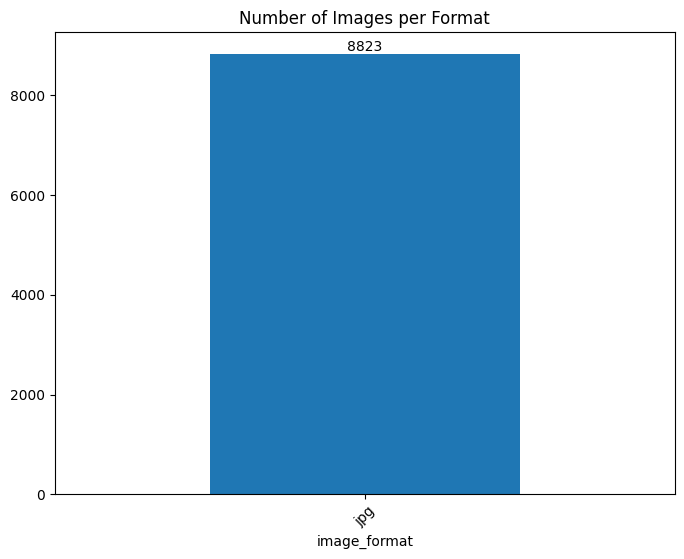

In [4]:
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_format' existe
    if 'image_format' not in df.columns:
        raise KeyError("A coluna 'image_format' não existe no DataFrame.")

    # Plotar gráfico
    ax = df['image_format'].value_counts().plot(
        kind='bar',
        title='Number of Images per Format',
        figsize=(8, 6)
    )

    plt.xticks(rotation=45)

    # Adicionar valores em cima das barras
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


### 5. Verificar a Consistência dos Metadados 🔧

#### Distribuição das dimensões (width x height):

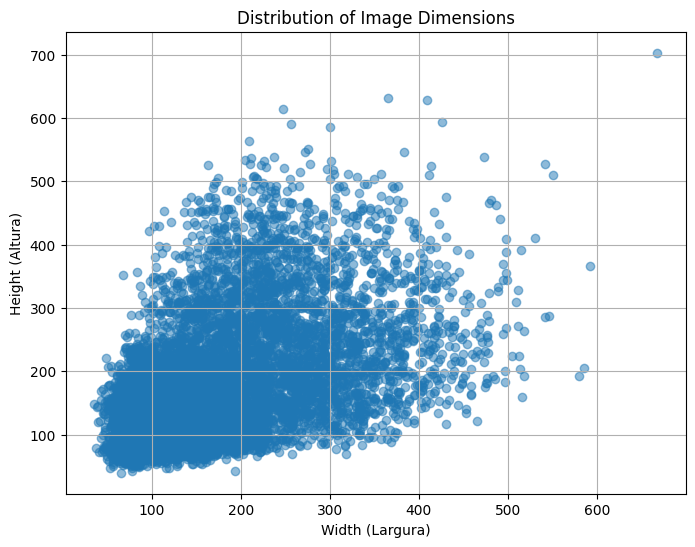

In [5]:
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se as colunas 'width' e 'height' existem
    if not {'width', 'height'}.issubset(df.columns):
        raise KeyError("As colunas 'width' e/ou 'height' não existem no DataFrame.")

    # Plotar o gráfico de dispersão
    plt.figure(figsize=(8, 6))
    plt.scatter(df['width'], df['height'], alpha=0.5)
    plt.xlabel('Width (Largura)')
    plt.ylabel('Height (Altura)')
    plt.title('Distribution of Image Dimensions')
    plt.grid(True)
    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


#### Informações nulas:

In [6]:
from IPython.display import display

try:
    # Verificar se o DataFrame df existe
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se há colunas no DataFrame
    if df.columns.size == 0:
        raise ValueError("O DataFrame 'df' não possui colunas.")

    # Verificar informações nulas
    print("Verificando informações nulas no dataset:")
    display(df.isnull().sum())

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Verificando informações nulas no dataset:


image_path      0
corrupted       0
image_hash      0
image_format    0
width           0
height          0
channels        0
label           0
dtype: int64

### 6. Analisar a Qualidade das Imagens 🧹

#### Total de imagens corrompidas:

In [7]:
try:
    # Verificar se o DataFrame existe
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'corrupted' existe
    if 'corrupted' not in df.columns:
        raise KeyError("A coluna 'corrupted' não existe no DataFrame.")

    # Realizar a contagem de imagens corrompidas
    total_corrupted = df['corrupted'].sum()

    print(f"Total de imagens corrompidas: {total_corrupted}")

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Total de imagens corrompidas: 0


#### Quantidade de imagens corrompidas e não corrompidas:

In [8]:
from IPython.display import display

try:
    # Verificar se o DataFrame existe
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'corrupted' existe
    if 'corrupted' not in df.columns:
        raise KeyError("A coluna 'corrupted' não existe no DataFrame.")

    # Exibir a quantidade de imagens corrompidas e não corrompidas
    result = df['corrupted'].value_counts()
    print("Quantidade de imagens corrompidas e não corrompidas gerada com sucesso!")
    display(result)

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Quantidade de imagens corrompidas e não corrompidas gerada com sucesso!


corrupted
False    8823
Name: count, dtype: int64

### 7. Verificar a Distribuição das Classes 📊 

Gráfico gerado com sucesso.


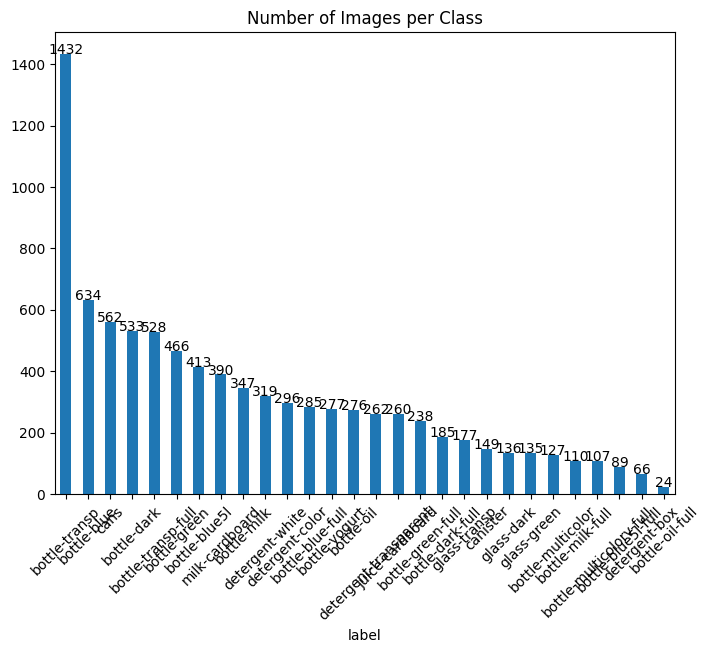

In [9]:
import matplotlib.pyplot as plt

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'label' existe
    if 'label' not in df.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame.")

    # Plotar gráfico da distribuição das classes
    ax = df['label'].value_counts().plot(
        kind='bar', 
        title='Number of Images per Class', 
        figsize=(8,6)
    )

    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())), 
            (p.get_x() + p.get_width()/2, p.get_height()), 
            ha='center'
        )

    print("Gráfico gerado com sucesso.")
    plt.show()

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


### 8. Verificar a Presença de Duplicatas 🧠 

#### Quantidade de duplicatas:

In [10]:
from IPython.display import display

try:
    # Verificar se o DataFrame existe e não está vazio
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_hash' existe
    if 'image_hash' not in df.columns:
        raise KeyError("A coluna 'image_hash' não existe no DataFrame.")

    # Calcular quantidade de duplicatas
    num_duplicatas = df['image_hash'].duplicated().sum()

    print(f"Quantidade de imagens duplicadas gerada com sucesso!")
    display(num_duplicatas)

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Quantidade de imagens duplicadas gerada com sucesso!


0

#### Visualizar duplicatas:

In [ ]:
# from IPython.display import display

# # df_duplicated = df[df['image_hash'].duplicated()]
# df_duplicated = df[df['image_hash'].duplicated(keep=False)]
# display(df_duplicated)


from IPython.display import display

try:
    # Verificar se o DataFrame existe
    if 'df' not in globals():
        raise NameError("O DataFrame 'df' não foi definido.")

    # Verificar se o DataFrame não está vazio
    if df.empty:
        raise ValueError("O DataFrame 'df' está vazio. Verifique se os dados foram carregados corretamente.")

    # Verificar se a coluna 'image_hash' existe
    if 'image_hash' not in df.columns:
        raise KeyError("A coluna 'image_hash' não existe no DataFrame.")

    # Filtrar imagens com hashes duplicados (mantém todas as ocorrências)
    df_duplicated = df[df['image_hash'].duplicated(keep=False)]

    # Verificar e exibir duplicatas, se houver
    if not df_duplicated.empty:
        print(f"Foram encontradas {df_duplicated.shape[0]} imagens duplicadas.")
        display(df_duplicated)
    else:
        print("Nenhuma imagem duplicada foi encontrada no dataset.")

except NameError as ne:
    print(ne)

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")



#### Exibir imagens duplicadas:

In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import os

try:
    # Verificações iniciais
    if 'df' not in globals() or df.empty:
        raise ValueError("O DataFrame 'df' não foi encontrado ou está vazio.")

    if 'df_duplicated' not in globals() or df_duplicated.empty:
        raise ValueError("Nenhuma imagem duplicada foi encontrada no dataset.")

    if 'image_hash' not in df.columns or 'image_path' not in df.columns:
        raise KeyError("As colunas necessárias 'image_hash' ou 'image_path' não existem no DataFrame.")

    # Criar dicionário de imagens duplicadas
    duplicated_images = {}
    for i in range(df_duplicated.shape[0]):
        hash_duplicated = df_duplicated.iloc[i]['image_hash']
        duplicated = df[df['image_hash'] == hash_duplicated]["image_path"].values
        duplicated_images[str(hash_duplicated)] = duplicated.tolist()

    # Verificar e exibir duplicatas
    if duplicated_images:
        display(duplicated_images)  # Mostrar o dicionário de duplicatas

        for hash_value, paths in duplicated_images.items():
            print(f"\nHash duplicado: {hash_value}")
            print(f"{len(paths)} imagens duplicadas encontradas:\n", paths)

            fig, axes = plt.subplots(1, len(paths), figsize=(5 * len(paths), 5))
            if len(paths) == 1:
                axes = [axes]  # Garante que seja iterável se só tiver uma imagem

            for ax, img_path in zip(axes, paths):
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        ax.imshow(img_rgb)
                        ax.set_title(os.path.basename(img_path))
                        ax.axis('off')
                    else:
                        ax.text(0.5, 0.5, "Imagem não pode ser carregada",
                                horizontalalignment='center',
                                verticalalignment='center')
                        ax.axis('off')
                else:
                    ax.text(0.5, 0.5, "Caminho não encontrado",
                            horizontalalignment='center',
                            verticalalignment='center')
                    ax.axis('off')

            plt.show()

    else:
        print("Nenhuma imagem duplicada foi encontrada no dataset.")

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


#### Gráficos de Duplicatas por Classe:

In [ ]:
import matplotlib.pyplot as plt

try:
    # Verifica se o DataFrame df_duplicated existe e não está vazio
    if 'df_duplicated' not in globals() or df_duplicated.empty:
        raise ValueError("Nenhuma duplicata encontrada no dataset.")

    # Verifica se a coluna 'label' existe
    if 'label' not in df_duplicated.columns:
        raise KeyError("A coluna 'label' não existe no DataFrame.")

    # Agrupar duplicatas por classe
    duplicates_by_class = df_duplicated.groupby('label').size()

    if not duplicates_by_class.empty:
        ax = duplicates_by_class.plot(
            kind='bar',
            title='Number of Duplicates per Class',
            figsize=(8, 6)
        )
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center'
            )
        plt.show()
    else:
        print("Nenhuma duplicata encontrada. Gráfico não gerado.")

except ValueError as ve:
    print(ve)

except KeyError as ke:
    print(ke)

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")
